# Testing AlexNet with convolution approach

AlexNet below is built based on code from [tensorflow website](https://github.com/tensorflow/models/blob/master/tutorials/image/cifar10/cifar10.py) and with some parameters (weight initialization standard deviation) tweaked according to chiyuan's code. Look [here](https://www.tensorflow.org/tutorials/deep_cnn) for more information. Another major change is that we are using the mean squared error rather than cross entropy loss (where the correct label is a 10-dimensional 1-hot vector):

$$ \ell = \frac{1}{N} \sum_{i=1}^N \left(y_i - g_w(x_i) \right)^2 $$

A prediction is made for sample $i$ using the argmax of $g_w(x_i)$. The novelty here is in the training process. Rather than using $g_w(x_i)$, we use $g_w(x_i)*p(x_i)$ for some distribution $p$ (we use a zero-mean normal distribution with varying variances). The $*$ here represents convolution. The idea is that by convolving $g_w$, our neural net output, with $p$, we regularize the objective such that only smooth (or spatially bandlimited) distributions $p(x,y)$ are obtained. As for implementation, We approximate

$$ g_w(x_i)*p(x_i) \approx \frac{1}{K}\sum_{i=1}^K g_w(x_i-x_k) $$

where $x_k$ are sampled from $p$. Importantly, ** the $x_k$ are resampled for each $x_i$ and for each epoch **. Therefore we simply replace each $x_i$ with its $K$ perturbed samples and solve the new objective above. This notebook attempts to do exactly that.

Tensorboard is implemented too. To use it, try

1. ```tensorboard --logdir SAVE_DIR --port PORT``` to start it at port PORT (6006 by default), then
2. ```ssh -fNL 16006:127.0.0.1:6006 user@ip``` to forward the port to your local machine (if the above command was run on a remote server)

In the code below, ```SAVE_DIR``` would correspond to ```save_dir+'/train'``` or ```save_dir+'/test'```, for example.

In [1]:
from __future__ import print_function
import tensorflow as tf
import numpy as np
import time,os,pickle
import matplotlib.pyplot as plt
from chiyuan_cifar10_jz import chiyuan,cifar10_parameters 
from sklearn.utils import shuffle
np.set_printoptions(precision=2,suppress=True)
%matplotlib inline

In [2]:
# The small Alexnet is constructed by two (convolution 5x5
# → max-pool 3x3 → local-response-normalization) modules followed by two fully connected layers
# with 384 and 192 hidden units, respectively. Finally a 10-way linear layer is used for prediction

def alexnet_arch(NUM_CLASSES):
    
    input_data = tf.placeholder(tf.float32, shape=[None, 28, 28, 3])
    input_labels = tf.placeholder(tf.float32, shape=[None,10])
    
    # conv1
    with tf.variable_scope('conv1') as scope:
        kernel = tf.get_variable('weights',[5, 5, 3, 64],
                                 initializer=tf.truncated_normal_initializer(stddev=1e-2))
        conv = tf.nn.conv2d(input_data, kernel, [1, 1, 1, 1], padding='SAME')
        biases = tf.get_variable('biases', [64], 
                                 initializer=tf.truncated_normal_initializer(stddev=1e-2))
        pre_activation = tf.nn.bias_add(conv, biases)
        conv1 = tf.nn.relu(pre_activation, name=scope.name)

    # pool1
    pool1 = tf.nn.max_pool(conv1, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1],
                           padding='VALID', name='pool1')
    # norm1
    norm1 = tf.nn.lrn(pool1, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75,
                      name='norm1')

    # conv2
    with tf.variable_scope('conv2') as scope:
        kernel = tf.get_variable('weights',[5, 5, 64, 64],
                                 initializer=tf.truncated_normal_initializer(stddev=1e-2))
        conv = tf.nn.conv2d(norm1, kernel, [1, 1, 1, 1], padding='SAME')
        biases = tf.get_variable('biases', [64], 
                                 initializer=tf.truncated_normal_initializer(stddev=1e-2))
        pre_activation = tf.nn.bias_add(conv, biases)
        conv2 = tf.nn.relu(pre_activation, name=scope.name)

    # pool2
    pool2 = tf.nn.max_pool(conv2, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1],
                           padding='VALID', name='pool2')

    # norm2
    norm2 = tf.nn.lrn(pool2, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75,
                      name='norm2')


    # local3
    with tf.variable_scope('local3') as scope:
        # Move everything into depth so we can perform a single matrix multiply.
        reshape = tf.reshape(norm2, [-1, 6*6*64])
        dim = reshape.get_shape()[1].value
        weights = tf.get_variable('weights',[dim, 384],
                                  initializer=tf.truncated_normal_initializer(stddev=4e-2))
        biases = tf.get_variable('biases', [384], 
                                 initializer=tf.truncated_normal_initializer(stddev=4e-2))
        local3 = tf.nn.relu(tf.matmul(reshape, weights) + biases, name=scope.name)

    # local4
    with tf.variable_scope('local4') as scope:
        weights = tf.get_variable('weights',[384, 192],
                                  initializer=tf.truncated_normal_initializer(stddev=4e-2))
        biases = tf.get_variable('biases', [192], 
                                 initializer=tf.truncated_normal_initializer(stddev=4e-2))
        local4 = tf.nn.relu(tf.matmul(local3, weights) + biases, name=scope.name)

    # linear layer(WX + b)
    with tf.variable_scope('linear') as scope:
        weights = tf.get_variable('weights',[192, NUM_CLASSES],
                                  initializer=tf.truncated_normal_initializer(stddev=1/192.0))
        biases = tf.get_variable('biases', [NUM_CLASSES], 
                                 initializer=tf.truncated_normal_initializer(stddev=1/192.0))
        linear = tf.add(tf.matmul(local4, weights), biases, name=scope.name)
        
    return input_data,input_labels,linear
    
# Squared loss between labels and output of linear activation function
def loss(g, Y, d, K):
    g_conv = tf.transpose(tf.reshape(tf.reduce_mean(tf.reshape(tf.transpose(g),[-1,K]),1),[d,-1]))
    return tf.reduce_mean(tf.reduce_sum(tf.pow(g_conv-Y,2),1))

# Accuracy
def acc(g, Y, d, K):
    g_conv = tf.transpose(tf.reshape(tf.reduce_mean(tf.reshape(tf.transpose(g),[-1,K]),1),[d,-1]))
    correct_prediction = tf.equal(tf.argmax(Y, 1), tf.argmax(g_conv, 1))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [3]:
# Use some image preprocessing stuff from chiyuan
#   - images are cropped to be 28x28x3 from 32x32x3
#   - images are also whitened 

def cifar_one_hot(i):
    v = np.zeros(10)
    v[i] = 1
    return v

def get_cifar10_dataset(p_corrupt_label,n_samps=50000,rand_seed=None):
    
    #  'SubS:tr:50000' means draw a random subset of 50000 samples for training (no replace)
    #  'RndL:trtt:100' means corrupt the train and test set labels with 100% probability
    class params(cifar10_parameters):
        def __init__(self,p,rand_seed,n_samp=50000):
            self.dataset = 'cifar10|SubS:tr:%s|RndL:trtt:%s'%(int(n_samp),int(p))
            self.rand_seed = rand_seed
#             self.per_image_whitening = False
    
    p = params(p_corrupt_label,rand_seed,n_samp=n_samps)
    c = chiyuan(p)
    _, datasets = c.prepare_inputs()
    return datasets[0][0],np.array(map(cifar_one_hot,datasets[0][1])), \
           datasets[1][0],np.array(map(cifar_one_hot,datasets[1][1]))

def graph_builder_wrapper(num_classes,K,sd,save_dir,lr_initial=0.01):
    
    input_data, input_labels, g_out = alexnet_arch(num_classes)
    saver = tf.train.Saver(max_to_keep=20)
    
    # Loss and optimizer
    K_graph = tf.Variable(K)
    total_loss = loss(g_out, input_labels, num_classes, K_graph, stddev=sd)
    learning_rate = tf.Variable(lr_initial, name='learning_rate')
    opt_step = tf.train.MomentumOptimizer(learning_rate,0.9).minimize(total_loss)
    tf.summary.scalar('loss', total_loss)
    
    # Accuracy
    total_acc = acc(g_out, input_labels, num_classes, K_graph)
    tf.summary.scalar('accuracy', total_acc)
    
    # Add histograms for trainable variables.
    for var in tf.trainable_variables():
        tf.summary.histogram(var.op.name, var)

    # Merge all the summaries and write them out to save_dir
    merged = tf.summary.merge_all()
    train_writer = tf.summary.FileWriter(save_dir + '/train')
    valid_writer = tf.summary.FileWriter(save_dir + '/validation')
    
    graph = dict( 
        input_data = input_data,
        input_labels = input_labels,
        K_graph = K_graph,
        total_loss = total_loss,
        total_acc = total_acc,
        g_out = g_out,
        opt_step = opt_step,
        learning_rate = learning_rate,
        merged = merged,
        train_writer = train_writer,
        valid_writer = valid_writer,
        saver = saver
    )
    
    return graph

# Augment dataset with perturbed samples
def append_noisy_samples(X,K=10,stddev=0.1):
    perturbations = np.random.normal(0,stddev,[len(X)*K]+list(np.shape(X))[1:])
    return np.repeat(X,K,axis=0)+perturbations

def train(Xtr,Ytr,Xva,Yva,graph,sd,K,save_dir,num_epochs=100,batch_size=100,save_every=1,verbose=True):
    
    training_losses,training_accs = [],[]
    validation_losses,validation_accs = [],[]
    with tf.Session() as sess:

        sess.run(tf.global_variables_initializer())

        for epoch in range(num_epochs):

            lr = 0.01*0.95**(epoch/390.) # initial lr * decay rate ^(step/decay_steps)
            sess.run(graph['learning_rate'].assign(lr))
            sess.run(graph['K_graph'].assign(K))

            t = time.time()
            training_loss = 0
            training_acc = 0
            steps = 0.
            Xtr_, Ytr_ = shuffle(Xtr,Ytr)

            if len(Xtr_)%batch_size == 0: end = len(Xtr_)
            else: end = len(Xtr_)-batch_size
            for i in range(0,end,batch_size):

                # Generate noisy samples for convolution estimation..
                x = append_noisy_samples(Xtr_[i:i+batch_size], K=K, stddev=sd)
                y = Ytr_[i:i+batch_size]

                feed_dict = {graph['input_data']: x, graph['input_labels']: y}

                summary,training_loss_,training_acc_,_ = sess.run([graph['merged'],graph['total_loss'],
                                                                   graph['total_acc'],graph['opt_step']],
                                                                  feed_dict=feed_dict)
                training_loss += training_loss_
                training_acc += training_acc_
                steps += 1.

                if verbose:
                    print('\rTraining batch %s/%s (%.3f s): loss %.3f, acc %.3f' \
                          %(steps,len(Xtr_)/batch_size,time.time()-t,training_loss_,training_acc_),end='')            
            
            if epoch%save_every == 0: 
                graph['train_writer'].add_summary(summary, epoch)
                
                # Get results on test set
                sess.run(graph['K_graph'].assign(1))
                feed_dict = {graph['input_data']: Xva, graph['input_labels']: Yva}
                summary,validation_loss,validation_acc = sess.run([graph['merged'],graph['total_loss'],
                                                                   graph['total_acc']],
                                                                  feed_dict=feed_dict)
                graph['valid_writer'].add_summary(summary, epoch)
                validation_losses.append(validation_loss)
                validation_accs.append(validation_acc)
                
                if not os.path.exists(save_dir+'checkpoints/'): os.mkdir(save_dir+'checkpoints/')
                graph['saver'].save(sess,save_dir+'checkpoints/epoch'+str(epoch))

            training_losses.append(training_loss/steps)
            training_accs.append(training_acc/steps)
            
            if verbose:
                print('Epoch: %s/%s done (Learning Rate: %.6f  Training Loss: %.3f)' \
                      %(epoch+1,num_epochs,lr,training_losses[-1]))
                
    return training_losses,training_accs,validation_losses,validation_accs


# Use trained model to predict
def predict(X,Y,graph,save_dir,batch_size=100,verbose=False,return_all=False):

    # Load from checkpoint corresponding to latest epoch 
    max_epoch = max([int(f.split('epoch')[1].split('.')[0]) for f in os.listdir(save_dir+'checkpoints/') if 'epoch' in f])
    t = time.time()
    with tf.Session() as sess:
        graph['saver'].restore(sess,save_dir+'checkpoints/epoch%s'%(max_epoch))

        sess.run(graph['K_graph'].assign(1))
        
        embedding = np.zeros((len(X),num_classes))
        overall_loss = 0
        overall_acc = 0
        steps = 0.
        for i in range(0,len(X),batch_size):
            g_,loss_,acc_ = sess.run([graph['g_out'],graph['total_loss'],graph['total_acc']], 
                                      feed_dict = {graph['input_data']:X[i:i+batch_size],
                                                   graph['input_labels']:Y[i:i+batch_size]})
            embedding[i:i+batch_size,:] = g_
            overall_loss += loss_
            overall_acc += acc_
            steps += 1
            if verbose: print('\r%s/%s samples processed.. (%.3f s elapsed)'%(i+1,len(X),time.time()-t),end='')

        overall_loss /= steps
        overall_acc /= steps
        
    if verbose: print('\nOverall accuracy (argmax of embeddings as labels): %.3f'%(overall_acc))
    if return_all: return overall_acc,overall_loss,embedding
    return overall_acc

In [4]:
# Original case (recreating results from authors. no convolution here)
# (i.e. just want to observe generalization getting worse with p_corrupt_label)

num_classes = 10
num_epochs = 100
batch_size = 100
K = 1
sd = 0.0
n_samps = 5000

list_p_corrupt_label = [0,20,40,60,80,100]

train_accs = np.zeros(len(list_p_corrupt_label))
test_accs = np.zeros(len(list_p_corrupt_label))

start = time.time()
for i,p_corrupt_label in enumerate(list_p_corrupt_label):

    save_dir = './temp/alexnet_K%s_sd%s_p%s/'%(K,sd,p_corrupt_label)

    tf.reset_default_graph()
    Xtr,Ytr,Xtt,Ytt = get_cifar10_dataset(p_corrupt_label,n_samps=n_samps)

    graph = graph_builder_wrapper(num_classes,K,sd,save_dir,lr_initial=0.01)
    
    if 'checkpoints' not in os.listdir(save_dir):
        tr_losses,tr_accs,va_losses,va_accs = train(Xtr,Ytr,Xtt,Ytt,graph,sd,K,save_dir,
                                                    num_epochs=num_epochs,batch_size=batch_size)
        train_accs[i] = tr_accs[-1]
        test_accs[i] = va_accs[-1]
    else:
        train_accs[i] = predict(Xtr,Ytr,graph,save_dir,batch_size=batch_size)
        test_accs[i] = predict(Xtt,Ytt,graph,save_dir,batch_size=batch_size)
    
    print('-'*80)
    print('Finished with K = %s, p_corrupt_label = %.3f, sd = %.2f (%.3f s elapsed)' \
          %(K,p_corrupt_label,sd,time.time()-start))
    print('  Train acc: %.2f, Test acc: %.2f'%(train_accs[i],test_accs[i]))
    print('-'*80)
    
out = {1:(train_accs,test_accs)}

--------------------------------------------------------------------------------
Finished with K = 1, p_corrupt_label = 0.000, sd = 0.00 (2.117 s elapsed)
  Train acc: 1.00, Test acc: 0.57
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Finished with K = 1, p_corrupt_label = 20.000, sd = 0.00 (3.696 s elapsed)
  Train acc: 1.00, Test acc: 0.39
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Finished with K = 1, p_corrupt_label = 40.000, sd = 0.00 (5.252 s elapsed)
  Train acc: 1.00, Test acc: 0.26
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Finished with K = 1, p_corrupt_label = 60.000, sd = 0.00 (6.853 s elapsed)
  Train acc: 1.00, Test acc: 0.1

In [ ]:
# Try averaging over K samples to improve generalization (convolution approach)

num_classes = 10
num_epochs = 100
batch_size = 100
n_samps = 5000

K = 50
batch_size = 50

list_p_corrupt_label = [0]
list_sd = [0.1,0.5,1,2,5]

train_accs = np.zeros((len(list_p_corrupt_label),len(list_sd)))
test_accs = np.zeros((len(list_p_corrupt_label),len(list_sd)))

start = time.time()
for i,p_corrupt_label in enumerate(list_p_corrupt_label):
    
    Xtr,Ytr,Xtt,Ytt = get_cifar10_dataset(p_corrupt_label,n_samps=n_samps)
    
    for j,sd in enumerate(list_sd):

        save_dir = './temp/alexnet_K%s_sd%s_p%s/'%(K,sd,p_corrupt_label)

        tf.reset_default_graph()
        graph = graph_builder_wrapper(num_classes,K,sd,save_dir,lr_initial=0.01)

        if 'checkpoints' not in os.listdir(save_dir):
            tr_losses,tr_accs,va_losses,va_accs = train(Xtr,Ytr,Xtt,Ytt,graph,sd,K,save_dir,
                                                        num_epochs=num_epochs,batch_size=batch_size)
            train_accs[i,j] = tr_accs[-1]
            test_accs[i,j] = va_accs[-1]
        else:
            train_accs[i,j] = predict(Xtr,Ytr,graph,save_dir,batch_size=batch_size)
            test_accs[i,j] = predict(Xtt,Ytt,graph,save_dir,batch_size=batch_size)

        print('-'*80)
        print('Finished with K = %s, p_corrupt_label = %.3f, sd = %.2f (%.3f s elapsed)' \
              %(K,p_corrupt_label,sd,time.time()-start))
        print('  Train acc: %.2f, Test acc: %.2f'%(train_accs[i,j],test_accs[i,j]))
        print('-'*80)
        
out[10] = (train_accs,test_accs)

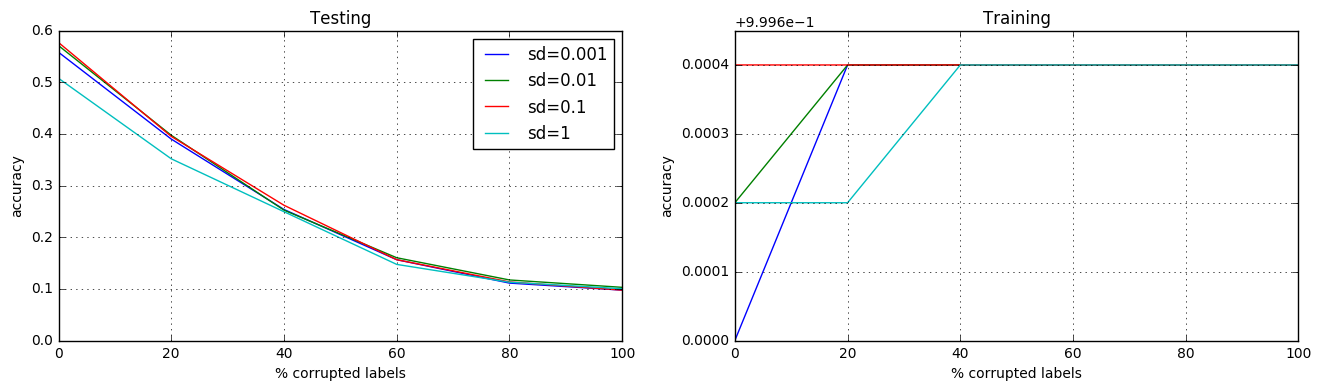

In [15]:
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
for i in range(len(list_sd)):
    plt.plot(list_p_corrupt_label,out[10][1][:,i],label='sd=%s'%(list_sd[i]))
plt.xlabel('% corrupted labels')
plt.ylabel('accuracy')
plt.title('Testing')
plt.legend()
plt.grid()
plt.subplot(1,2,2)
for i in range(len(list_sd)):
    plt.plot(list_p_corrupt_label,out[10][0][:,i],label='sd=%s'%(list_sd[i]))
plt.xlabel('% corrupted labels')
plt.ylabel('accuracy')
plt.title('Training')
plt.grid()

### Misc

In [ ]:
# # For Debugging
# tf.reset_default_graph()

# x = tf.constant([[10.,10.],[10.,10.]])
# y = tf.constant([[10.2,10.1],[10.2,10.1]])
# l = tf.reduce_sum(tf.pow(x-y,2),1)
# with tf.Session() as sess:
#     sess.run(tf.global_variables_initializer())
#     print(sess.run(l))

In [ ]:
# # Testing to make sure the loss function is written correctly..
# K = 40
# n = 10
# d = 2
# Z = np.random.choice(range(10),(n,d))
# Zp = append_noisy_samples(Z,K=K,stddev=0.01)
# Z_ = np.mean(Zp.T.reshape(-1,K),1).reshape(d,-1).T
# print(Z)
# print(Z_)

# z = tf.placeholder(tf.float32, shape=[n*K,d])
# z_ = tf.transpose(tf.reshape(tf.reduce_mean(tf.reshape(tf.transpose(z),[-1,K]),1),[d,-1]))

# with tf.Session() as sess:
#     sess.run(tf.global_variables_initializer())
#     test = sess.run(z_, feed_dict = {z: Zp})
    
# print(test)